# Matching

In [1]:
%plot -f SVG

In [2]:
RF_Track;


RF-Track, version 2.3.3a0

Copyright (C) 2016-2025 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track

RF-Track was compiled with GSL-2.7 and fftw-3.3.10



## Bunch parameters

In [3]:
%% Bunch parameters
mass = RF_Track.electronmass; % MeV/c^2
charge = -1; % single-particle charge, in units of e
population = 1*RF_Track.nC; % number of real particles per bunch
Pc = 5; % reference momentum, MeV/c
P_Q = Pc / charge; % MV/c, reference rigidity

## FODO cell parameters
If the quadrupoles have a length, the analytic formulae we used in the previous example won't provide a periodic solution.

In [4]:
%% FODO cell parameters
Lcell = 2; % m
Lquad = 0.2; % m
Ldrift = Lcell/2 - Lquad; % m

mu = 90; % deg
k1L = sind(mu/2) / (Lcell/4); % 1/m, integrated normalised strength

strength = k1L * P_Q; % MeV/m, quadrupole strength

## Let's define the elements

In [5]:
% Half a focusing quadrupole
Qf = Quadrupole(Lquad/2, strength/2);
Qf.set_tt_nsteps(10);

% A full, defocusing, quadrupole
QD = Quadrupole(Lquad, -strength);
QD.set_tt_nsteps(20);

% The drift
Dr = Drift(Ldrift);
Dr.set_tt_nsteps(30); % transport table

# Let's define a lattice with 10 FODO cells

In [6]:
FODO = Lattice ();
FODO.append (Qf); % half quad
FODO.append (Dr);
FODO.append (QD); % full defocusing quadrupole
FODO.append (Dr);
FODO.append (Qf); % half quad

L = Lattice();
for i=1:10
    L.append (FODO)
end

In [7]:
L.get_length()

ans = 20


In [8]:
L.size()

ans = 10


# ...and a bunch
Let's start form the analytic solution

In [9]:
%% Define Twiss parameters
Twiss = Bunch6d_twiss();
Twiss.emitt_x = 0.001; % mm.mrad, normalized emittances
Twiss.emitt_y = 0.001; % mm.mrad
Twiss.alpha_x = 0.0;
Twiss.alpha_y = 0.0;
Twiss.beta_x = Lcell * (1 + sind(mu/2)) / sind(mu); % m
Twiss.beta_y = Lcell * (1 - sind(mu/2)) / sind(mu); % m
Twiss.sigma_t = 0; % mm/c
Twiss.sigma_pt = 0; % permille, 1%

%% Create the bunch
B0 = Bunch6d(mass, population, charge, Pc, Twiss, 10000);

In [10]:
beta_x = Twiss.beta_x
beta_y = Twiss.beta_y

beta_x = 3.4142
beta_y = 0.5858


# Then, we can perform tracking

In [11]:
B1 = L.track(B0);

We can inquire the lattice to find out, for example, the Twiss parameters and the emittance

In [12]:
T = L.get_transport_table('%S %beta_x %beta_y %emitt_x %emitt_y %sigma_x %sigma_y %emitt_4d');

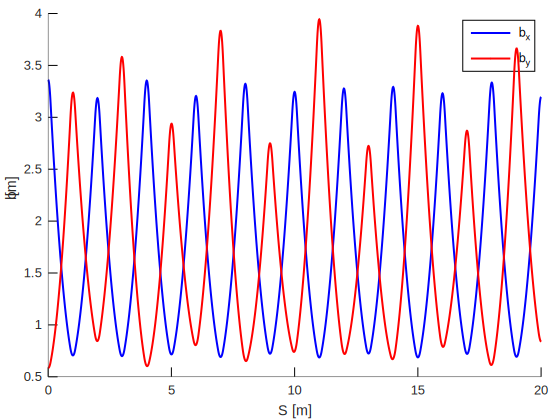

In [13]:
hold on
plot(T(:,1), T(:,2), 'b-', 'linewidth', 2);
plot(T(:,1), T(:,3), 'r-', 'linewidth', 2);
legend({ '\beta_x', '\beta_y' });
xlabel('S [m]');
ylabel('\beta [m]');

# Now we can match the Twiss paramters to be periodic
## Start with defining a merit function
This function returns zero when the initial and the final Twiss parameters are identical

In [14]:
function M = match_K1 (strength, FODO, B0)
    RF_Track;

    % Get quadrupoles from FODO
    Q = FODO.get_quadrupoles();
    Q{1}.set_strength ( strength/2);
    Q{2}.set_strength (-strength);
    Q{3}.set_strength ( strength/2);

    % Perform tracking
    B1 = FODO.track(B0);
    I0 = B0.get_info();
    I1 = B1.get_info();
    
    % Compute the merit function
    M = (I1.beta_x - I0.beta_x)^2 + ...
        (I1.beta_y - I0.beta_y)^2 + ...
        (I1.alpha_x + I0.alpha_x)^2 + ... % final alpha = -initial alpha
        (I1.alpha_y + I0.alpha_y)^2 ;

    disp([ strength M ]);
end

Now, call the minization function ```fminbnd (@func, xmin, xmax)```

In [15]:
merit = @(S) match_K1 (S, FODO, B0, Twiss.beta_x, Twiss.beta_y);

O = optimset('TolX', 1e-15);
strength = fminbnd (@(S) merit(S), -10, -5)

  -8.090170   0.048694
  -6.9098   0.1592
  -8.8197   0.7551
  -7.5842e+00   5.3402e-03
  -7.6760e+00   9.6568e-04
  -7.7041e+00   5.0299e-04
  -7.7219e+00   4.3369e-04
  -7.7201e+00   4.3263e-04
  -7.7199e+00   4.3263e-04
  -7.7199e+00   4.3263e-04
  -7.7199e+00   4.3263e-04
strength = -7.7199


And build a new lattice with the matched FODO

In [16]:
L = Lattice();
for i=1:10
    L.append (FODO)
end

In [17]:
B1 = L.track(B0);

In [18]:
T = L.get_transport_table('%S %beta_x %beta_y %emitt_x %emitt_y %sigma_x %sigma_y %emitt_4d');

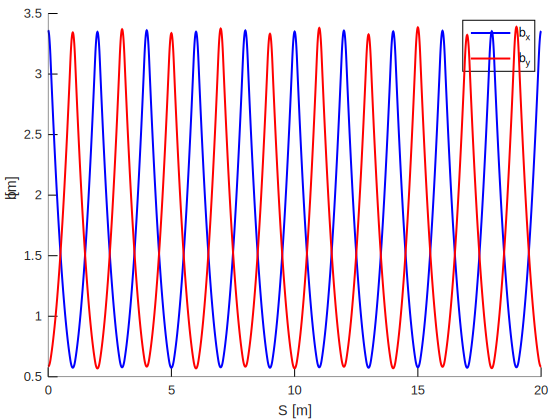

In [19]:
hold on
plot(T(:,1), T(:,2), 'b-', 'linewidth', 2);
plot(T(:,1), T(:,3), 'r-', 'linewidth', 2);
legend({ '\beta_x', '\beta_y' });
xlabel('S [m]');
ylabel('\beta [m]');